From the Kaggle competition description:

"In this playground competition, hosted in partnership with Google Cloud and Coursera, you are tasked with predicting the fare amount (inclusive of tolls) for a taxi ride in New York City given the pickup and dropoff locations. While you can get a basic estimate based on just the distance between the two points, this will result in an RMSE of $5-$8, depending on the model used (see the starter code for an example of this approach in Kernels). Your challenge is to do better than this using Machine Learning techniques!"



In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm
#from sklearn.model_selection import StratifiedShuffleSplit

First issue: train.csv is massive! (5.7 gb) 
Therefore the file must be read and processed in chunks.
However, when using pd.read_csv(PATH, chunksize=X), the data type returned is a 'TextFileReader' object.

I do not know how to work with the chunksize argument so I'll just use a limited number of rows (10,000,000) for now.


In [4]:
#trainRawChunks = pd.read_csv("/home/mitchell/Desktop/kaggleData/taxiFareKaggle/all/train.csv", chunksize=500)
#testRaw = pd.read_csv("/home/mitchell/Desktop/kaggleData/taxiFareKaggle/all/test.csv")

#count = 0
#for chunk in trainRawChunks:
#    print(chunk.shape)
#    count += 1
    
#print("There are: ", 500 * count, "rows")
    
#trainRawChunks[0].head()

In [5]:
numberOfSamples = 500000

#LAPTOP PATH: "/home/mitchell/Desktop/kaggleData/taxiFareKaggle/all/train.csv"
#DESKTOP PATH: "/media/mitch/Data/kaggleData/taxiFareKaggleData/all/train.csv"

trainRawSegment = pd.read_csv("/media/mitch/Data/kaggleData/taxiFareKaggleData/all/train.csv", nrows=numberOfSamples)




My Laptop seems to be able to handle 5,000,000 lines of data quite easily (It only has 8 Gb of RAM). Since only a portion of the total data supplied is being used, this already gives the model a disadvantage but also room for improvement if needed.

In [6]:
print(trainRawSegment.shape)
trainRawSegment.head()

(500000, 8)


,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


Firstly, the raw data will be shuffled even though there seems to be no pattern of how it was input to the dataset. This is so when the validation set is separated from the training set, there is a fair representation of data in each. However, scikit-learn's stratified shuffle split can be used to ensure that this happens. This function also does the separation of the two datasets automatically based on the argument that is passed. 

For this implementation, a simple shuffle of the dataset and then use of the head() and tail() functions will be used to create a 80/20 split of the raw data.

In [7]:
np.random.seed(0)
trainRawSegment = trainRawSegment.iloc[np.random.permutation(np.arange(len(trainRawSegment)))]
trainRawSegment.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
194257,2014-06-17 18:09:09.0000001,24.5,2014-06-17 18:09:09 UTC,-74.010745,40.709325,-73.924750,40.690980,2
396319,2013-09-01 09:26:00.00000041,6.5,2013-09-01 09:26:00 UTC,-73.992822,40.728227,-74.002087,40.738277,2
138738,2010-06-29 21:19:00.000000216,6.9,2010-06-29 21:19:00 UTC,-73.990750,40.730687,-73.990847,40.749648,1
66570,2010-11-23 12:51:18.0000001,4.1,2010-11-23 12:51:18 UTC,-74.005450,40.745924,-73.998245,40.756035,1
149424,2009-11-24 15:50:59.0000002,11.7,2009-11-24 15:50:59 UTC,-73.980270,40.745946,-73.976583,40.780798,1


In [8]:
#must typecast to int for head and tail to work as it doesn't handle floating point numbers.

train = trainRawSegment.head(int(numberOfSamples*0.8))
validation = trainRawSegment.tail(int(numberOfSamples*0.2))

In [9]:
print(train.shape)
print(validation.shape)

(400000, 8)
(100000, 8)


Looking through the data, things that stand out are dates and times in the "key" & "pickup_datetime" columns. These could be split into separate individual features and checked for correlation with "fare_amount". The pairs of longitude and latitude features could be made into cross features. Time could be bucketed into morning, afternoon and evening categories.

In [10]:
train["passenger_count"].value_counts()
print(len(train.columns))

8


Inspection of the "passenger_count" column shows some crazy errors. specifically the taxis that were able to fit 49 to 208 passengers in the one trip. In all seriousness, this looks like an input error or error code. The trips that noted 9 passengers down are a bit of a mystery, as either it was a data entry error or possibly those taxis did actually have that many passengers. 

These outliers (passenger_count > 6) will be removed from the dataset as they hold such an insignificant percentage of data 11/5,000,000.

In [11]:
#removing the weird passenger count 
train = train.drop(train[train.passenger_count > 6].index)
print("train is now ", int(train.size/len(train.columns)), "rows long")
train["passenger_count"].value_counts()

train is now  400000 rows long


1    276829
2     59140
5     28238
3     17460
4      8466
6      8432
0      1435
Name: passenger_count, dtype: int64

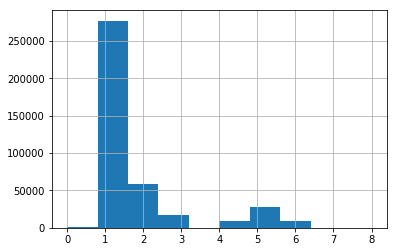

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
train["passenger_count"].hist(bins=10, range=(0, 8))
plt.show()

Using pandas corr function, the correlation between columns can be acquired.  

In [13]:
corrMatrix = train.corr()
corrMatrix["fare_amount"]

fare_amount          1.000000
pickup_longitude     0.010054
pickup_latitude     -0.008599
dropoff_longitude    0.010870
dropoff_latitude    -0.008449
passenger_count      0.013913
Name: fare_amount, dtype: float64

There is no feature that has an obvious correlation with fare_amount. Passenger_count has the highest correlation with the target value fare_amount out of the data provided. This is probably due to larger groups of people taking longer trips together to save on costs.

As this function only provides correlation of linear relationships, it is missing out on the non-linear relationships. Next up, testing with different combinations of features. The main combination that will be tested is distance travelled. This will be found by taking the absolute of pythagorean distance of pickup_longitude minus dropoff_longitude and pickup_latitude minus dropoff_latitude.  

This next code iterates through the training set, calculating the distance between pickup and dropoff locations and assigning them to the distance_travelled column.

In [14]:
##################################################################
#
#
#         DONT RUN THIS CELL
#       This has been kept to show what not to do!
#
#
##################################################################
'''

# https://stackoverflow.com/questions/19412462/getting-distance-between-two-points-based-on-latitude-longitude

from math import sin, cos, sqrt, atan2, radians

train.loc[:, "distance_travelled"] = np.nan

trainLength = len(train["passenger_count"])

# approximate radius of earth in km
R = 6373.0

for i in tqdm(range(trainLength)):
    lat1 = radians(train["pickup_latitude"].iloc[i])
    lon1 = radians(train["pickup_longitude"].iloc[i])
    lat2 = radians(train["dropoff_latitude"].iloc[i])
    lon2 = radians(train["dropoff_longitude"].iloc[i])
    
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    
    train.loc[train.index[i], "distance_travelled"] = R * c
    
train.head()
'''




'\n\n# https://stackoverflow.com/questions/19412462/getting-distance-between-two-points-based-on-latitude-longitude\n\nfrom math import sin, cos, sqrt, atan2, radians\n\ntrain.loc[:, "distance_travelled"] = np.nan\n\ntrainLength = len(train["passenger_count"])\n\n# approximate radius of earth in km\nR = 6373.0\n\nfor i in tqdm(range(trainLength)):\n    lat1 = radians(train["pickup_latitude"].iloc[i])\n    lon1 = radians(train["pickup_longitude"].iloc[i])\n    lat2 = radians(train["dropoff_latitude"].iloc[i])\n    lon2 = radians(train["dropoff_longitude"].iloc[i])\n    \n    dlon = lon2 - lon1\n    dlat = lat2 - lat1\n    \n    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2\n    c = 2 * atan2(sqrt(a), sqrt(1 - a))\n    \n    train.loc[train.index[i], "distance_travelled"] = R * c\n    \ntrain.head()\n'

Using tqdm on the iterator, we see that this calculation will take approx. 72 hours for the 4 million samples. This is way too long. I'm going to have to figure out another way to calculate this feature. (cython, some other software that is fast dealing with large datasets).

Before processing latitude and longitude, I should have inspected the data thoroughly beforehand. Using the tool provided on https://www.mapdevelopers.com/geocode_bounding_box.php I can get a bounding box around new york city, find minimum and maximum latitude and longitude values, and filter the training data using the found values. This should remove any errors acquired at time of input, and remove any locations that have been input that arent in new york city. 
![new york city latitude and longitude limits](img/boundingBox.png)

Using the latitude and longitude bounds created by the map developer tool above, I'll add an extra +/- 1 to longitude and +/- 0.5 to latitude and filter using the values. This is done to include any trips that begin/end in the outer suburbs. These values could be tweaked to increase the area sample size as well. 

In [15]:
# change these values to increase/decrease bounding box size
longitudeBound = np.array([-72.7, -75.26])
latitudeBound = np.array([41.42, 39.98])

print("train was ", int(train.size/len(train.columns)), "rows long")

# longitudes first
train = train.drop(train[train.pickup_longitude > longitudeBound[0]].index)
train = train.drop(train[train.pickup_longitude < longitudeBound[1]].index)
train = train.drop(train[train.dropoff_longitude > longitudeBound[0]].index)
train = train.drop(train[train.dropoff_longitude < longitudeBound[1]].index)

# now the latitudes
train = train.drop(train[train.pickup_latitude > latitudeBound[0]].index)
train = train.drop(train[train.pickup_latitude < latitudeBound[1]].index)
train = train.drop(train[train.dropoff_latitude > latitudeBound[0]].index)
train = train.drop(train[train.dropoff_latitude < latitudeBound[1]].index)

print("train is now ", int(train.size/len(train.columns)), "rows long")

#removing the weird passenger count 
#train = train.drop(train[train.passenger_count > 6].index)
#print("train is now ", int(train.size/len(train.columns)), "rows long")
#train["passenger_count"].value_counts()

train was  400000 rows long
train is now  391676 rows long


Next up, I'm going to sort the pickup_datetime column into individual columns. This is so I can categorize and bucketize parameters individually. Also, I believe I can safely remove the key column as this just seems to have the same info but in a worse format. 

In [16]:
train = train.drop("key", axis=1)

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
194257,24.5,2014-06-17 18:09:09 UTC,-74.010745,40.709325,-73.924750,40.690980,2
396319,6.5,2013-09-01 09:26:00 UTC,-73.992822,40.728227,-74.002087,40.738277,2
138738,6.9,2010-06-29 21:19:00 UTC,-73.990750,40.730687,-73.990847,40.749648,1
66570,4.1,2010-11-23 12:51:18 UTC,-74.005450,40.745924,-73.998245,40.756035,1
149424,11.7,2009-11-24 15:50:59 UTC,-73.980270,40.745946,-73.976583,40.780798,1


In [17]:
train["pickup_datetime"] = pd.to_datetime(train["pickup_datetime"])
train.dtypes

fare_amount                 float64
pickup_datetime      datetime64[ns]
pickup_longitude            float64
pickup_latitude             float64
dropoff_longitude           float64
dropoff_latitude            float64
passenger_count               int64
dtype: object

In [18]:
train['year'] = train['pickup_datetime'].dt.year
train['month'] = train['pickup_datetime'].dt.month
train['date'] = train['pickup_datetime'].dt.day
train['day'] = train['pickup_datetime'].dt.dayofweek
train['hour'] = train['pickup_datetime'].dt.hour

After seperating the datetime field into different units of time, I can do some analysis. First I'll check what year all this data has come from. 

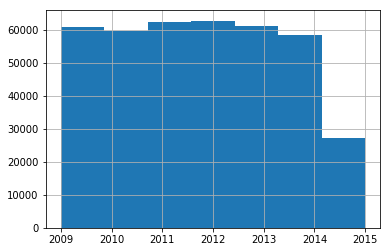

In [19]:
train["year"].hist(bins=7)
plt.show()

Obviously the data hasnt been sampled throughout the entire year of 2015 and i have only got data from approximately half the year here. Im just going to confirm that by plotting a scatterplot of month against year.

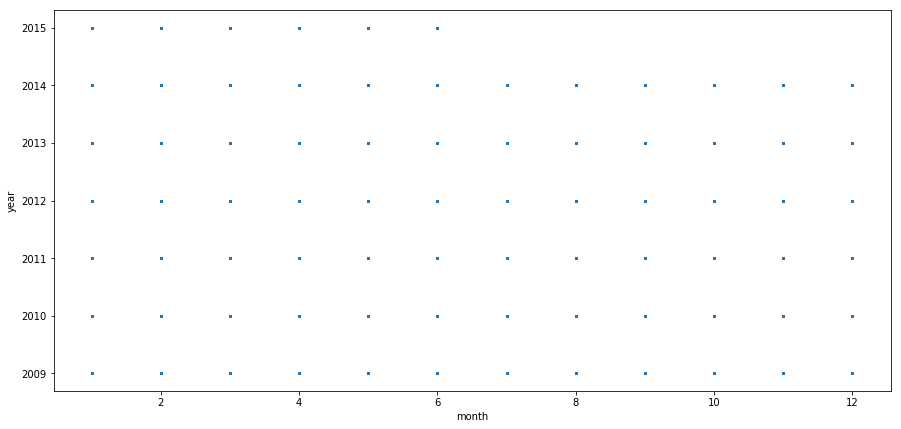

In [20]:
plt.figure(figsize=(15,7))
plt.scatter(x=train['month'], y=train['year'], s=1.5)
plt.xlabel('month')
plt.ylabel('year')
plt.show()

As predicted, the data only goes up to june 2015. There was no way that taxi rides dropped in popularity that severely.

In [21]:
corrMatrix = train.corr()
corrMatrix["fare_amount"]

fare_amount          1.000000
pickup_longitude     0.367308
pickup_latitude     -0.182040
dropoff_longitude    0.288988
dropoff_latitude    -0.149473
passenger_count      0.014746
year                 0.115434
month                0.024509
date                 0.002469
day                  0.003924
hour                -0.019750
Name: fare_amount, dtype: float64

Seems after cancelling out a bunch of longitude and latitudes, the pickup and dropoff longitude shows much stronger correlation than before. 

When was rush hour in NYC in the year 2012? this could be a valuable parameter that correlates well with fare amount. According to a local, "Rush hour in NYC is usually from about 7:00am-10:00am and 4:00pm-7:00pm during the week". With this info we can create a new boolean feature called rush_hour.

In [22]:
train["rush_hour"] = ((train["hour"] < 10) & (train["hour"] > 7)) | ((train["hour"] < 19) & (train["hour"] > 16))

Which days fall on weekends? which are during the week? I believe this parameter might have strong correlation with fare amount. Using dt.dayofweek results in values for the day of the week being Monday=0, Sunday=6.

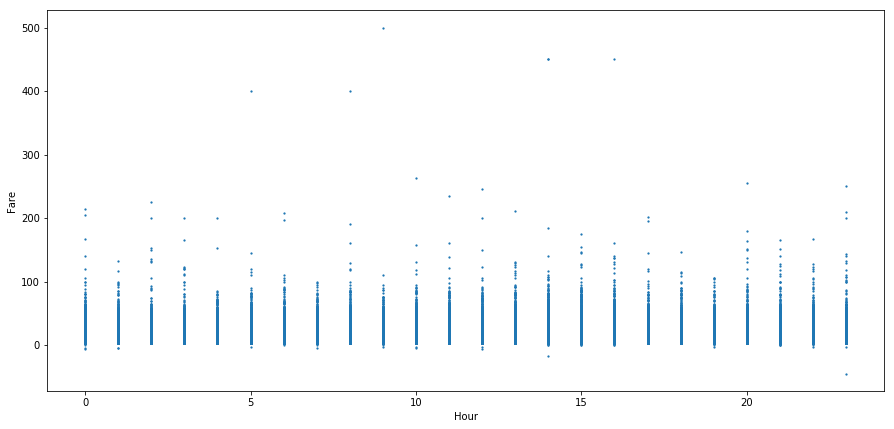

In [24]:
plt.figure(figsize=(15,7))
plt.scatter(x=train['hour'], y=train['fare_amount'], s=1.5)
plt.xlabel('Hour')
plt.ylabel('Fare')
plt.show()

I was hoping to reveal some interesting insight to how fares differ by looking at the fare_amount vs. hour scatterplot. Unfortunatley, not a huge distinction between AM/PM, night/day can be identified. However, an obvious fault in the dataset did occur. We can see some records have negative fare_amounts. This doesn't make any sense, so I'll remove them. Also a few huge fare amounts are recorded (400 - 980) but I'll leave them for now.

In [25]:
print("train was ", int(train.size/len(train.columns)), "rows long")
train = train.drop(train[train.fare_amount < 0].index)
train.describe()
print("train is now ", int(train.size/len(train.columns)), "rows long")

train was  391676 rows long
train is now  391660 rows long


Awesome, no negative fare pricings (though a cost of zero seems a little strange but possible).
Next up, an attempt at vectorizing the distance travelled calculation.

In [26]:
# approximate radius of earth in km
R = 6373.0

lat1 = np.radians(np.array(train["pickup_latitude"]))
lon1 = np.radians(np.array(train["pickup_longitude"]))
lat2 = np.radians(np.array(train["dropoff_latitude"]))
lon2 = np.radians(np.array(train["dropoff_longitude"]))
    
dlon = lon2 - lon1
dlat = lat2 - lat1
    
a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    
train["distance_travelled"] = c * R

WOah! after learning about how to use numpy properly, I tried vectorizing the equation using the built in numpy functions which resulted in insane speed. This really shows the power of the numpy library when comparing to how I previously coded it using a for loop and math library functions. 72 hours vs. approx. 100ms... actually insane.

Now that I have The distance travelled (point to point, not directly following the exact route taken) I can test the correlation between fare amount and distance travelled.

In [27]:
corrMatrix = train.corr()
print(corrMatrix["fare_amount"])
print(" ")
print(train["distance_travelled"].describe())

fare_amount           1.000000
pickup_longitude      0.367412
pickup_latitude      -0.182058
dropoff_longitude     0.289168
dropoff_latitude     -0.149487
passenger_count       0.014744
year                  0.115483
month                 0.024433
date                  0.002480
day                   0.003950
hour                 -0.019770
rush_hour            -0.017939
distance_travelled    0.803089
Name: fare_amount, dtype: float64
 
count    391657.000000
mean          3.330704
std           3.769211
min           0.000000
25%           1.255258
50%           2.151759
75%           3.922107
max         110.867870
Name: distance_travelled, dtype: float64


As expected, a really strong correlation occurs. I'm now going to have a quick look at the data using the describe function. As above, it seems that most of the data falls within an expected range, however, the largest value is 132 kilometers, which seems really unbelievable. I am going to plot the distance travelled against pickup latitude to try visualize outliers. 

After plotting distance travelled vs pickup latitude, I found the plot difficult to read. though there were some strange patterns occuring, I thought perhaps they were natural and not a bug/data entry error (considering there may be some really common tourist destinations that alot of people from a common pickup location, such as the airport, could be the case). I then decided to plot year vs distance travelled and found some interesting patterns as below...

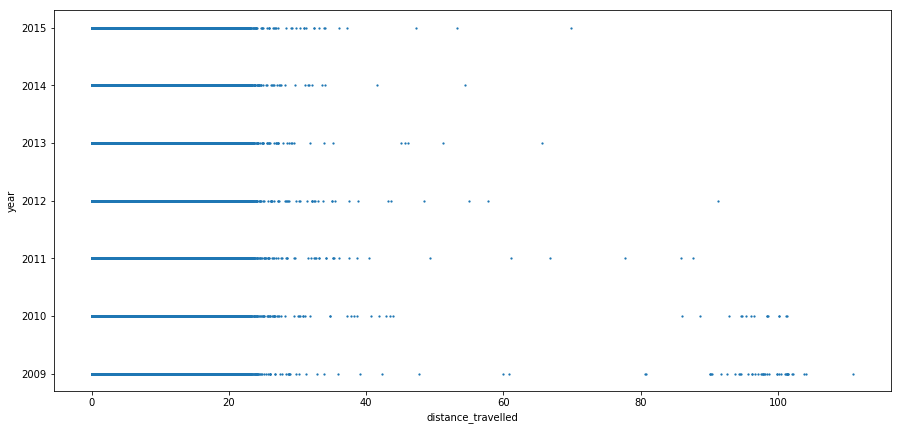

In [28]:
plt.figure(figsize=(15,7))
plt.scatter(x=train['distance_travelled'], y=train['year'], s=1.5)
plt.xlabel('distance_travelled')
plt.ylabel('year')
plt.show()

Looking at distance travelled against year, it seems like alot of the longer rides start to cease at around 2011-2012. I was thinking that a public transport system to the airport had gone live or something along those lines, but in fact, Uber went live in May 2011 according to wikipedia, and I think this would have had a large enough impact to change these trends.

NEXT UP:

- should i do some bucketizing? (months into seasons, winter may have a higher taxi trip rate) 
- I still need to standardize or normalize the quantative features (only fitting the transformer to the training data, then, transforming the training, test and future data) .  
- I should treat the date-based features as categorical instead of a quantative variable. (One hot encoding)

In [29]:
train.rush_hour = train.rush_hour.astype(int)
train.dtypes

fare_amount                  float64
pickup_datetime       datetime64[ns]
pickup_longitude             float64
pickup_latitude              float64
dropoff_longitude            float64
dropoff_latitude             float64
passenger_count                int64
year                           int64
month                          int64
date                           int64
day                            int64
hour                           int64
rush_hour                      int64
distance_travelled           float64
dtype: object

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,date,day,hour,rush_hour,distance_travelled
194257,24.5,2014-06-17 18:09:09,-74.010745,40.709325,-73.924750,40.690980,2,2014,6,17,1,18,1,7.533312
396319,6.5,2013-09-01 09:26:00,-73.992822,40.728227,-74.002087,40.738277,2,2013,9,1,6,9,1,1.363604
138738,6.9,2010-06-29 21:19:00,-73.990750,40.730687,-73.990847,40.749648,1,2010,6,29,1,21,0,2.109045
66570,4.1,2010-11-23 12:51:18,-74.005450,40.745924,-73.998245,40.756035,1,2010,11,23,1,12,0,1.278050
149424,11.7,2009-11-24 15:50:59,-73.980270,40.745946,-73.976583,40.780798,1,2009,11,24,1,15,0,3.889007


Upon attempting to one hot encode the training data, it is found that NaNs exist in the data. In this instance, all NaNs will be set to 0, further testing will be done later to try other methods.

In [31]:
train.fillna(0, inplace=True)

Not sure if standardize/normalize is needed here, as I'll only use one continuous variable (distance travelled). One hot encoding on the other had will definitely be used.

In [32]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler

columns_to_scale  = ['distance_travelled']
scaler = StandardScaler()
train[columns_to_scale]  = scaler.fit_transform(train[columns_to_scale]) 

The above attempt at scaling and one hot encoding froze my computer. most likely a RAM issue. I think I've got to bucketize some of the categorical data first before one hot encoding. Alternatively I could use a smaller dataset.

In [34]:
train['distance_travelled'].describe()

count    3.916600e+05
mean     1.059483e-17
std      1.000001e+00
min     -8.836559e-01
25%     -5.506313e-01
50%     -3.127793e-01
75%      1.569071e-01
max      2.853049e+01
Name: distance_travelled, dtype: float64

In [35]:
train = pd.get_dummies(train, columns=['passenger_count'])

In [36]:
train = pd.get_dummies(train, columns=['year'])

lets drop the pickup_datetime column as it is a datetime64[ns] object which we cannot use.  The longitude and latitude recordings will also be removed as Ive caclulated the distance travelled. This could be a terrible idea, but I am not sure how to handle this data. Do I bucketize it, then one hot encode? - something to research.

In [37]:
train = train.drop("pickup_datetime", axis=1)
train = train.drop("pickup_longitude", axis=1)
train = train.drop("pickup_latitude", axis=1)
train = train.drop("dropoff_longitude", axis=1)
train = train.drop("dropoff_latitude", axis=1)

,fare_amount,month,date,day,hour,rush_hour,distance_travelled,passenger_count_0,passenger_count_1,passenger_count_2,...,passenger_count_4,passenger_count_5,passenger_count_6,year_2009,year_2010,year_2011,year_2012,year_2013,year_2014,year_2015
194257,24.5,6,17,1,18,1,1.114993,0,0,1,...,0,0,0,0,0,0,0,0,1,0
396319,6.5,9,1,6,9,1,-0.521881,0,0,1,...,0,0,0,0,0,0,0,1,0,0
138738,6.9,6,29,1,21,0,-0.324109,0,1,0,...,0,0,0,0,1,0,0,0,0,0
66570,4.1,11,23,1,12,0,-0.544579,0,1,0,...,0,0,0,0,1,0,0,0,0,0
149424,11.7,11,24,1,15,0,0.148129,0,1,0,...,0,0,0,1,0,0,0,0,0,0
128165,8.5,2,22,5,1,0,-0.080359,0,0,1,...,0,0,0,0,0,0,0,0,1,0
264495,19.5,7,18,4,17,1,0.833122,0,0,0,...,0,0,1,0,0,0,0,0,1,0
30371,15.5,10,13,5,19,0,0.212138,0,0,0,...,1,0,0,0,0,0,1,0,0,0
456998,9.5,1,31,3,7,0,0.083186,0,1,0,...,0,0,0,0,0,0,0,1,0,0
32001,8.1,2,14,0,11,0,-0.339020,0,1,0,...,0,0,0,0,0,1,0,0,0,0


In [38]:
train = train.drop("month", axis=1)
train = train.drop("date", axis=1)
train = train.drop("hour", axis=1)
train = pd.get_dummies(train, columns=['day'])

,fare_amount,rush_hour,distance_travelled,passenger_count_0,passenger_count_1,passenger_count_2,passenger_count_3,passenger_count_4,passenger_count_5,passenger_count_6,...,year_2013,year_2014,year_2015,day_0,day_1,day_2,day_3,day_4,day_5,day_6
194257,24.5,1,1.114993,0,0,1,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
396319,6.5,1,-0.521881,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
138738,6.9,0,-0.324109,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
66570,4.1,0,-0.544579,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
149424,11.7,0,0.148129,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
128165,8.5,0,-0.080359,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
264495,19.5,1,0.833122,0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,1,0,0
30371,15.5,0,0.212138,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
456998,9.5,0,0.083186,0,1,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
32001,8.1,0,-0.339020,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [39]:
# Divide this data into training data and label data
trainTargets = train["fare_amount"]
trainData = train.drop("fare_amount", axis=1)

my model will go here: (most likely a pytorch neural network)

Below I've defined a function that process a dataframe into the correct format that the samples need to be in in order to produce a prediction.

In [51]:
def preprocess(data):
    
    # this "filtering" is not used:
    
#    train = train.drop(train[train.passenger_count > 6].index)    
#    longitudeBound = np.array([-72.7, -75.26])
#    latitudeBound = np.array([41.42, 39.98])
#    longitudes first
#    train = train.drop(train[train.pickup_longitude > longitudeBound[0]].index)
#    train = train.drop(train[train.pickup_longitude < longitudeBound[1]].index)
#    train = train.drop(train[train.dropoff_longitude > longitudeBound[0]].index)
#    train = train.drop(train[train.dropoff_longitude < longitudeBound[1]].index)
#    now the latitudes
#    train = train.drop(train[train.pickup_latitude > latitudeBound[0]].index)
#    train = train.drop(train[train.pickup_latitude < latitudeBound[1]].index)
#    train = train.drop(train[train.dropoff_latitude > latitudeBound[0]].index)
#    train = train.drop(train[train.dropoff_latitude < latitudeBound[1]].index)

    #data = data.drop(data[data.fare_amount < 0].index)
 
    # replace NaNs with zeros
    data.fillna(0, inplace=True)
    data = data.drop("key", axis=1)
    
    # process the dates.
    data["pickup_datetime"] = pd.to_datetime(data["pickup_datetime"])
    data['year'] = data['pickup_datetime'].dt.year
    data['month'] = data['pickup_datetime'].dt.month
    data['date'] = data['pickup_datetime'].dt.day
    data['day'] = data['pickup_datetime'].dt.dayofweek
    data['hour'] = data['pickup_datetime'].dt.hour
    
    #create the rush hour column
    data["rush_hour"] = ((data["hour"] < 10) & (data["hour"] > 7)) | ((data["hour"] < 19) & (data["hour"] > 16))
    data.rush_hour = data.rush_hour.astype(int)
    
    
    # create the distance_travelled column
    R = 6373.0
    lat1 = np.radians(np.array(data["pickup_latitude"]))
    lon1 = np.radians(np.array(data["pickup_longitude"]))
    lat2 = np.radians(np.array(data["dropoff_latitude"]))
    lon2 = np.radians(np.array(data["dropoff_longitude"]))
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    data["distance_travelled"] = c * R

    #scale the continuous data
    columns_to_scale  = ['distance_travelled']
    scaler = StandardScaler()
    data[columns_to_scale]  = scaler.fit_transform(data[columns_to_scale]) 

    #one hot encode categorical data
    data = pd.get_dummies(data, columns=['passenger_count'])
    data = pd.get_dummies(data, columns=['year'])
    data = pd.get_dummies(data, columns=['day'])

    #drop certain columns - subject to change
    data = data.drop("pickup_datetime", axis=1)
    data = data.drop("pickup_longitude", axis=1)
    data = data.drop("pickup_latitude", axis=1)
    data = data.drop("dropoff_longitude", axis=1)
    data = data.drop("dropoff_latitude", axis=1)    
    data = data.drop("month", axis=1)
    data = data.drop("date", axis=1)
    data = data.drop("hour", axis=1)
    
    return data


This next cell will seperate both the train and validation set data from the target (fare_amount).
The trainData will be the pre-processed, clean training set, while the validation data is still raw and unfiltered, hopefully positively simulating the test set. The reason for doing this now is so that while filterign and processing the training data, we want to make sure the data and the target matrices are the same row length for our machine learning framework of choice.

In [53]:
validation = preprocess(validation)

validation.head(10)

# Divide this data into training data and label data

validationTargets = validation["fare_amount"]
validationData = validation.drop("fare_amount", axis=1)

/home/mitch/anaconda3/envs/machineLearning/lib/python3.6/site-packages/pandas/core/frame.py:3790: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


I'll make the predictions here: